# Lane Detection with TuSimple Dataset
Using U-Net
1. Configuration
2. Data Preprocessing (JSON to Masks)
3. Dataset Loading
4. Model Architecture (U-Net)
5. Training Loop
6. Inference & Visualization
7. Execution
8. Evaluation

Save the Confusion Matrix while the training, after the validation. 

In [1]:
import os
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt


## 1. Configuration
Define paths, hyperparameters, and device settings.


In [22]:
# Paths
BASE_DIR = os.getcwd()
DATA_DIR = r'C:\ADAS_Project\TUSimple_Small' 
TRAIN_SET_DIR = os.path.join(DATA_DIR, 'train_set')
TEST_SET_DIR = os.path.join(DATA_DIR, 'test_set')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, 'processed')
CHECKPOINT_DIR = os.path.join(BASE_DIR, 'checkpoints')

# Create directories
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Hyperparameters
EPOCHS = 5 #20+ for final training
BATCH_SIZE = 8 #calculate based on GPU memory
LEARNING_RATE = 5*1e-4 
WEIGHT_DECAY = 1e-4 
NUM_CLASSES = 2  # Background + Lane
IMG_HEIGHT = 288 # Resize target height
IMG_WIDTH = 512  # Resize target width

# Model Save Path with Hyperparameters
model_filename = f'best_model_e{EPOCHS}_bs{BATCH_SIZE}_lr{LEARNING_RATE}.pth'
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, model_filename)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## 2. Data Preprocessing
Functions to parse TuSimple JSON labels and generate segmentation masks.


In [3]:
def process_tusimple_data(data_dir, output_dir, json_files):
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for json_file in json_files:
        json_path = os.path.join(data_dir, json_file)

        with open(json_path, 'r') as openfile: #read json file 
            lines = openfile.readlines()

        for line in tqdm(lines, desc=f"Processing {json_file}"):
            info = json.loads(line)
            raw_file = info['raw_file']
            lanes = info['lanes']
            h_samples = info['h_samples']
            
            # Create mask (assuming 1280x720 original size)
            mask = np.zeros((720, 1280), dtype=np.uint8)

            # Filter out empty lanes, -2 for no lane coordinate
            valid_lanes = []
            for lane in lanes:
                if any(x != -2 for x in lane):
                    valid_lanes.append(lane)
            
            # Draw all valid lanes with class ID 1
            for lane in valid_lanes:
                points = []
                for x, y in zip(lane, h_samples):
                    if x != -2:
                        points.append((x, y))
                
                if len(points) > 1:
                    cv2.polylines(mask, [np.array(points, dtype=np.int32)], isClosed=False, color=1, thickness=10)
            # Save mask
            mask_rel_path = raw_file.replace('.jpg', '.png')
            mask_save_path = os.path.join(output_dir, mask_rel_path)
            
            os.makedirs(os.path.dirname(mask_save_path), exist_ok=True)
            cv2.imwrite(mask_save_path, mask)


## 3. Dataset Definition
PyTorch Dataset class to load images and masks.


In [4]:
class TuSimpleDataset(Dataset):
    def __init__(self, root_dir, processed_dir, json_files, transform=None):
        self.root_dir = root_dir
        self.processed_dir = processed_dir
        self.transform = transform
        self.samples = []

        # Load all samples from json files
        for json_file in json_files:
            json_path = os.path.join(root_dir, json_file)
            if not os.path.exists(json_path):
                continue
                
            with open(json_path, 'r') as f:
                lines = f.readlines()
            
            for line in lines:
                info = json.loads(line)
                raw_file = info['raw_file']
                mask_file = raw_file.replace('.jpg', '.png')
                
                # Check if mask exists
                if os.path.exists(os.path.join(processed_dir, mask_file)):
                    self.samples.append((raw_file, mask_file))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_rel_path, mask_rel_path = self.samples[idx]
        
        img_path = os.path.join(self.root_dir, img_rel_path)
        mask_path = os.path.join(self.processed_dir, mask_rel_path)
        
        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Resize
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
        
        # Normalize image
        image = image.astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1)) # HWC -> CHW
        
        # Convert to tensor
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).long()
        
        return image, mask


## 4. Model Architecture (U-Net)
Standard U-Net implementation.


In [5]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        # Two consecutive convolutional layers with Batch Normalization and ReLU activation
        # padding=1
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # MaxPool2d(2) reduces the spatial dimensions by half (e.g., 256x256 -> 128x128)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # Upsample the feature map to increase spatial dimensions
        if bilinear:
            # Bilinear interpolation for upsampling (no learnable parameters)
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            # Transposed convolution for upsampling (learnable parameters)
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1: Feature map from the previous layer (to be upsampled)
        # x2: Feature map from the corresponding encoder layer (skip connection)
        x1 = self.up(x1)
        
        # Calculate the difference in size between x1 (upsampled) and x2 (skip connection)
        # This handles cases where input dimensions are not perfectly divisible by 2^depth
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # Pad x1 to match the size of x2
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # Concatenate along the channel dimension (dim=1)
        # This is the "Skip Connection" that re-introduces spatial information
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        # 1x1 convolution to map feature channels to the number of classes
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoder (Contracting Path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder: Capture context
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Decoder: Precise localization using skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Final classification
        logits = self.outc(x)
        return logits

## 5. Training Loop


In [6]:
def train_model():
    # Dataset
    json_files = ['label_data_0313.json', 'label_data_0531.json', 'label_data_0601.json']
    
    full_dataset = TuSimpleDataset(TRAIN_SET_DIR, PROCESSED_DATA_DIR, json_files)

    # Split into train and val
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Model
    model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(device) #channels for R,G,B 

    # Loss and optimizer
    class_weights = torch.tensor([0.5, 1.0], device=device) # Background, Lane
    criterion_ce = nn.CrossEntropyLoss(weight=class_weights)
    
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # Training loop

    best_val_loss = float('inf') # Checkpoint: set the best val to infinity at first

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for images, masks in loop:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            
            # CE Loss
            loss_ce = criterion_ce(outputs, masks)
            loss = loss_ce

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item(), ce=loss_ce.item())

        avg_train_loss = train_loss / len(train_loader)
        
        # Validation, no_grad for validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                
                loss_ce = criterion_ce(outputs, masks)
                loss = loss_ce
                
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print("Saved best model checkpoint.")


## 6. Inference & Visualization


In [7]:
def lane_detection_prediction(image_path, model_path, output_path):
    # Load model
    model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Load image
    original_image = cv2.imread(image_path)

    image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = image.astype(np.float32) / 255.0
    image = np.transpose(image, (2, 0, 1))
    image = torch.from_numpy(image).float().unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        output = model(image)
        probs = torch.softmax(output, dim=1)
        pred_mask = torch.argmax(probs, dim=1).squeeze(0).cpu().numpy()
    
    # Visualization
    pred_mask_resized = cv2.resize(pred_mask.astype(np.uint8), (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    colors = [
        [0, 0, 0],       # Background
        [0, 255, 0]      # Lane (Green)
    ]
    
    overlay = np.zeros_like(original_image)
    for i in range(1, NUM_CLASSES):
        overlay[pred_mask_resized == i] = colors[i]

    alpha = 0.5
    result = cv2.addWeighted(original_image, 1, overlay, alpha, 0)

    cv2.imwrite(output_path, result)
    print(f"Saved result to {output_path}")
    
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## 7. Execution
Run the following cells to process data and train the model.


In [8]:
# 1. Run Preprocessing
json_files = ['label_data_0313.json', 'label_data_0531.json', 'label_data_0601.json']
process_tusimple_data(TRAIN_SET_DIR, PROCESSED_DATA_DIR, json_files)

Processing label_data_0601.json: 100%|██████████| 110/110 [00:00<00:00, 191.98it/s]


In [9]:
# 2. Train Model
train_model()

Epoch 1/5: 100%|██████████| 102/102 [21:11<00:00, 12.47s/it, ce=0.157, loss=0.157]


Epoch [1/5], Train Loss: 0.2513, Val Loss: 0.1727
Saved best model checkpoint.


Epoch 2/5: 100%|██████████| 102/102 [20:00<00:00, 11.77s/it, ce=0.118, loss=0.118]


Epoch [2/5], Train Loss: 0.1389, Val Loss: 0.2414


Epoch 3/5: 100%|██████████| 102/102 [19:45<00:00, 11.62s/it, ce=0.119, loss=0.119]  


Epoch [3/5], Train Loss: 0.1147, Val Loss: 0.1114
Saved best model checkpoint.


Epoch 4/5: 100%|██████████| 102/102 [20:33<00:00, 12.09s/it, ce=0.101, loss=0.101]  


Epoch [4/5], Train Loss: 0.0973, Val Loss: 0.0987
Saved best model checkpoint.


Epoch 5/5: 100%|██████████| 102/102 [19:24<00:00, 11.42s/it, ce=0.07, loss=0.07]    


Epoch [5/5], Train Loss: 0.0832, Val Loss: 0.0806
Saved best model checkpoint.


Saved result to inference_result.jpg


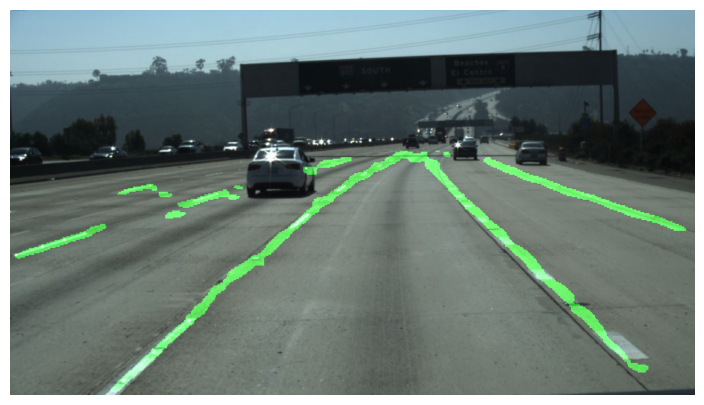

In [15]:
# 3. Inference
test_image_path = os.path.join(TRAIN_SET_DIR, 'clips/0313-1/660/20.jpg') # Example image
output_image_path = 'inference_result.jpg'
lane_detection_prediction(test_image_path, BEST_MODEL_PATH, output_image_path)

## 8. Evaluation
Calculate IoU, Dice Score, and Accuracy on the Test Set.


In [16]:
def calculate_metrics(pred_mask, true_mask, num_classes):
    # pred_mask, true_mask: [H, W]
    iou_per_class = []
    dice_per_class = []
    
    for cls in range(num_classes):
        pred_cls = (pred_mask == cls)
        true_cls = (true_mask == cls)
        
        intersection = np.logical_and(pred_cls, true_cls).sum()
        union = np.logical_or(pred_cls, true_cls).sum()
        
        if union == 0:
            iou = float('nan') # Ignore if class not present
            dice = float('nan')
        else:
            iou = intersection / union
            dice = 2 * intersection / (pred_cls.sum() + true_cls.sum())
            
        iou_per_class.append(iou)
        dice_per_class.append(dice)
        
    accuracy = (pred_mask == true_mask).sum() / pred_mask.size
    
    return iou_per_class, dice_per_class, accuracy

def evaluate(model, test_loader, device):
    model.eval()
    total_iou = []
    total_dice = []
    total_acc = []
    
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.cpu().numpy() # Ground truth
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().numpy()
            
            for i in range(len(masks)):
                iou, dice, acc = calculate_metrics(preds[i], masks[i], NUM_CLASSES)
                total_iou.append(iou)
                total_dice.append(dice)
                total_acc.append(acc)
                
    # Average metrics (ignoring NaNs)
    mean_iou = np.nanmean(total_iou, axis=0)
    mean_dice = np.nanmean(total_dice, axis=0)
    mean_acc = np.mean(total_acc)
    
    print(f"Mean Accuracy: {mean_acc:.4f}")
    print(f"Mean IoU per class: {mean_iou}")
    print(f"Mean Dice per class: {mean_dice}")
    print(f"Mean IoU (Lanes): {np.nanmean(mean_iou[1:])}") # Exclude background
    print(f"Mean Dice (Lanes): {np.nanmean(mean_dice[1:])}")

In [ ]:
# 1. Process Test Set Labels
test_json_files = ['test_label.json']
process_tusimple_data(TEST_SET_DIR, PROCESSED_DATA_DIR, test_json_files)

# 2. Create Test Dataset and Loader
test_dataset = TuSimpleDataset(TEST_SET_DIR, PROCESSED_DATA_DIR, test_json_files)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 3. Run Evaluation
model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))

evaluate(model, test_loader, device)


Processing test_label.json: 100%|██████████| 278/278 [00:00<00:00, 280.37it/s]


Loaded best model.


Evaluating: 100%|██████████| 35/35 [01:25<00:00,  2.45s/it]

Mean Accuracy: 0.9807
Mean IoU per class: [0.98038172 0.47404301]
Mean Dice per class: [0.9900812  0.63606638]
Mean IoU (Lanes): 0.4740430135102604
Mean Dice (Lanes): 0.6360663816191723
